In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as skmts
import scipy.stats as scistat
import glob
plt.style.use('fivethirtyeight')
import gseapy as gp
import pathlib

In [2]:
"""
Parse CCLE datasets

download link: https://depmap.org/portal/download/all/
version: Public 22Q4
"""

import pathlib
import numpy as np
import pandas as pd

import sklearn.preprocessing as skpre

class ParseCCLE:
    """
    """
    def __init__(self, root=None, omics=None, model=None, transformed="MinMax", debug=False):
        self.transformed = transformed
        self.debug = debug
        self.omics = omics

        # set root      
        if root is None:
            raise Exception(f'Error, file path is required!!!')
        else:
            if pathlib.Path(root).is_file():
                self.root = root
            else:
                raise Exception(f'Error, file={root} not found!!!')


        # set omics
        if self.omics is None:
            raise Exception(f'Error, omics is required, [exp, cnv, mut, ef, es, grn, bgrn, tfgrn, btfgrn, bes, bef]!!!')

        elif self.omics in ['exp', 'cnv', 'ef', 'es', 'grn', 'bgrn', 'tfgrn', 'btfgrn', 'bes', 'bef']: # tfgrn: tf-gene regulatory network from GRAND
            # grn, bgrn, tfgrn, btfgrn are data from GRAND, representing tf-gene regulatory network
            # grn: gene by ach_id, computed TF-Gene targeting scores, averaging across TFs
            # bgrn: binarized grn, 1: grn>0 and 0 otherwise
            # tfgrn: tf by ach_id, computed TF-Gene targeting scores, averaging across Genes
            # btfgrn: binarized tfgrn, 1: tfgrn>0 and 0 otherwise
            self.df = pd.read_csv(self.root, header=0, index_col=0)
        elif self.omics == 'mut':
            col_list = ['RefCount', 'AltCount', 'DepMap_ID', 'HugoSymbol']
            self.df = pd.read_csv(self.root, header=0, usecols=col_list, low_memory=False)
        else:
            raise Exception(f'Error, omics={omics} not supported!!!')

        # set model
        if model is None:
            raise Exception(f'Error, file path is required!!!')
        else:
            if pathlib.Path(model).is_file():
                col_list = ['ModelID', 'CCLEName', 'OncotreeLineage', 'OncotreePrimaryDisease']
                self.model = pd.read_csv(model, header=0, usecols=col_list)

            else:
                raise Exception(f'Error, file={model} not found!!!')

    def get_processed_data(self):
        # omics data
        if self.omics == 'exp':
            df = self.clean_exp(self.df)
        elif self.omics == 'cnv':
            df = self.clean_cnv(self.df)
        elif self.omics == 'mut':
            df = self.clean_mut(self.df)
        elif self.omics == 'ef':
            df = self.clean_ef(self.df)
        elif self.omics == 'bef':
            df = self.clean_binary_ef(self.df)
        elif self.omics == 'es':
            df = self.clean_es(self.df)
        elif self.omics == 'bes':
            df = self.clean_binary_es(self.df)
        elif self.omics == 'grn':
            df = self.clean_grn(self.df)
        elif self.omics == 'bgrn':
            df = self.clean_binary_grn(self.df)
        elif self.omics == 'tfgrn':
            df = self.clean_tfgrn(self.df)
        elif self.omics == 'btfgrn':
            df = self.clean_binary_tfgrn(self.df)
        else:
            raise Exception(f'Error, omics={self.omics} not supported!!!')

        if np.isnan(df.sum().sum()):
            raise ValueError(f'Error, input contains nan!!!')

        # model annotation
        model = self.clean_model(self.model)
        # subsetting to include cell line with model annotation
        cell_list = sorted(list(set(model['depmap_id']) & set(df.columns)))
        model = model[model['depmap_id'].isin(cell_list)]
        df = df[cell_list]
        return df, model
    
    

    def clean_model(self, df):
        """
        note: map TCGA study abbreviation:
        https://gdc.cancer.gov/resources-tcga-users/tcga-code-tables/tcga-study-abbreviations
        ACH-000043: non-cancerous fibroblasts
        """
        df.rename(columns={'ModelID':'depmap_id', 'CCLEName':'ccle_name'}, inplace=True)
        name_abb_dict = {'Ovarian Epithelial Tumor':'TCGA_OV', 'Acute Myeloid Leukemia':'TCGA_LAML',
                         'Colorectal Adenocarcinoma':'TCGA_COAD', 'Melanoma':'TCGA_SKCM',
                         'Bladder Urothelial Carcinoma':'TCGA_BLCA', 'Non-Small Cell Lung Cancer':'TCGA_LUSC',
                         'Renal Cell Carcinoma':'TCGA_KIRC', 'Invasive Breast Carcinoma':'TCGA_BRCA',
                         'Pancreatic Adenocarcinoma': 'TCGA_PAAD', 'Non-Hodgkin Lymphoma':'TCGA_DLBC',
                         'Diffuse Glioma':'TCGA_GBM', 'Esophagogastric Adenocarcinoma':'TCGA_STAD',
                         'Prostate Adenocarcinoma': 'TCGA_PRAD', 'Pleural Mesothelioma': 'TCGA_MESO',
                         'Ovarian Germ Cell Tumor': 'TCGA_OV', 'Hepatocellular Carcinoma': 'TCGA_LIHC',
                         'Rhabdomyosarcoma':'TCGA_SARC', 'Sarcoma, NOS':'TCGA_SARC', 'Ewing Sarcoma':'TCGA_SARC',
                         'Fibrosarcoma':'TCGA_SARC', 'Well-Differentiated Thyroid Cancer':'TCGA_THCA',
                         'Myeloproliferative Neoplasms':'TCGA_LCML',
                         'B-Lymphoblastic Leukemia/Lymphoma':'NA', 'Meningothelial Tumor':'NA',
                         'Embryonal Tumor':'NA', 'Hodgkin Lymphoma':'NA'}
        df.loc[:, 'tcga abbrev'] = df.loc[:, 'OncotreePrimaryDisease'].replace(to_replace=name_abb_dict)

        if self.debug:
            ori_disease = df['OncotreePrimaryDisease'].unique()
            abb_disease = [name for name, abb in name_abb_dict.items() if abb != 'NA']
            not_found = list(set(ori_disease)-set(abb_disease))
            print(f'# primary disease={len(ori_disease)}')
            print(f'# of diseases have TCGA Abbreviation={len(abb_disease)}')
            print(f'# of diseases not in TCGA study={len(not_found)}')
            print(f'not yet found\n{not_found}')

        return df

    def _transform_data(self, df, method='MinMax'):
        """return transformed data"""
        # choose scaler
        if method == 'Standard':
            scaler = skpre.StandardScaler()
        elif method == 'MinMax':
            scaler = skpre.MinMaxScaler()
        elif method == 'Power':
            scaler = skpre.PowerTransformer(method='yeo-johnson', standardize=True)
        else:
            raise ValueError(f'{method} is not supported, try Standard or MinMax!!!')

        # transform data
        eps = 1e-6
        data_arr = scaler.fit_transform(df.values+eps)
        df = pd.DataFrame(data_arr, columns=df.columns, index=df.index)
        return df
    
    
    def clean_grn(self, df):
        """
        return dataframe with gene by sample 
        
        update: MinMax scaling to make sure no negative values
        """
        if df.isnull().sum().sum() > 0:
            df.fillna(0, inplace=True) # fill missing value with 0

        col_list = [col.split(' ')[0] for col in df.columns]
        df.columns = col_list # use Gene Symbol instead of ID

        #if self.transformed is not None:
        #    df = self._transform_data(df, method=self.transformed)
        df = self._transform_data(df, method='MinMax')

        if self.debug:
            print(f'#genes={len(df.T)} |#samples={len(df)}')
        return df.T # gene by sample

    def clean_binary_grn(self, df):
        """
        return dataframe with gene by sample 
        
        """
        if df.isnull().sum().sum() > 0:
            df.fillna(0, inplace=True) # fill missing value with 0

        col_list = [col.split(' ')[0] for col in df.columns]
        df.columns = col_list # use Gene Symbol instead of ID

        # binarize probabilites of tf-targeted genes
        df = df.applymap(lambda x: 1 if x>0 else 0)

        if self.debug:
            print(f'#genes={len(df.T)} |#samples={len(df)}')
        return df.T # gene by sample


    def clean_tfgrn(self, df):
        """
        return dataframe with tf by sample

        update: MinMax scaling to make sure no negative values
        """
        if df.isnull().sum().sum() > 0:
            df.fillna(0, inplace=True) # fill missing value with 0

        col_list = [col.split(' ')[0] for col in df.columns]
        df.columns = col_list # use Gene Symbol instead of ID

        #if self.transformed is not None:
        #    df = self._transform_data(df, method=self.transformed)
        df = self._transform_data(df, method='MinMax')

        if self.debug:
            print(f'#TFs={len(df.T)} |#samples={len(df)}')
        return df.T # TF by sample
    
    def clean_binary_tfgrn(self, df):
        """
        return dataframe with tf by sample
        """
        if df.isnull().sum().sum() > 0:
            df.fillna(0, inplace=True) # fill missing value with 0

        col_list = [col.split(' ')[0] for col in df.columns]
        df.columns = col_list # use Gene Symbol instead of ID

        # binarize probabilites of tf-targeting
        df = df.applymap(lambda x: 1 if x>0 else 0)

        if self.debug:
            print(f'#TFs={len(df.T)} |#samples={len(df)}')
        return df.T # TF by sample

    def clean_exp(self, df):
        """
        return dataframe with gene by sample 
        
        """
        if df.isnull().sum().sum() > 0:
            df.fillna(0, inplace=True) # fill missing value with 0

        col_list = [col.split(' ')[0] for col in df.columns]
        df.columns = col_list # use Gene Symbol instead of ID

        if self.transformed is not None:
            df = self._transform_data(df, method=self.transformed)

        if self.debug:
            print(f'#genes={len(df.T)} |#samples={len(df)}')
        return df.T # gene by sample

    def clean_cnv(self, df):
        """
        return dataframe with gene by sample

        """
        if df.isnull().sum().sum() > 0:
            df.fillna(0, inplace=True) # fill missing value with 0

        col_list = [col.split(' ')[0] for col in df.columns]
        df.columns = col_list # use Gene Symbol instead of ID

        if self.transformed is not None:
            df = self._transform_data(df, method=self.transformed)

        if self.debug:
            print(f'#genes={len(df.T)} |#samples={len(df)}')
        return df.T # gene by sample
    
    def clean_mut(self, df):
        """
        return dataframe with gene by sample

        """
        sub_df = df.groupby(['DepMap_ID', 'HugoSymbol']).agg({'AltCount': 'sum', 'RefCount': 'sum'})
        sub_df['MutationRate'] = sub_df['AltCount']/(sub_df['RefCount']+sub_df['AltCount'])
        sub_df = sub_df.reset_index()
        sub_df = pd.pivot(sub_df, index='HugoSymbol', columns='DepMap_ID', values='MutationRate')
        sub_df[sub_df == np.inf] = 0
        sub_df.fillna(0, inplace=True)

        df = sub_df.rename_axis(index=None)
        df = df.rename_axis(None, axis=1)

        if self.transformed is not None:
            df = self._transform_data(df, method=self.transformed)

        if self.debug:
            print(f'#genes={len(df)} |#samples={len(df.T)}')
            print(f'summary stats of mutation rate per sample\n{df.describe()}')
        return df

    def clean_ef(self, df):
        """
        return dataframe with gene by sample 
        
        update: MinMax scaling to make sure no negative values
        """
        if df.isnull().sum().sum() > 0:
            df.fillna(0, inplace=True) # fill missing value with 0

        col_list = [col.split(' ')[0] for col in df.columns]
        df.columns = col_list # use Gene Symbol instead of ID

        #if self.transformed is not None:
        #    df = self._transform_data(df, method=self.transformed)
        df = self._transform_data(df, method='MinMax')

        if self.debug:
            print(f'#genes={len(df.T)} |#samples={len(df)}')
        return df.T # gene by sample

    def clean_binary_ef(self, df):
        """
        return dataframe with gene by sample

        """
        if df.isnull().sum().sum() > 0:
            df.fillna(0, inplace=True) # fill missing value with 0

        col_list = [col.split(' ')[0] for col in df.columns]
        df.columns = col_list # use Gene Symbol instead of ID

        # binarize probabilites of being non-essential gene distribution
        # ef < -0.5 represents significat essential, while ef < -1 indicates strong killing
        df = df.applymap(lambda x: 1 if x<-0.5 else 0)

        if self.debug:
            print(f'#genes={len(df.T)} |#samples={len(df)}')
        return df.T # gene by sample

    def clean_es(self, df):
        """
        return dataframe with gene by sample

        """
        if df.isnull().sum().sum() > 0:
            df.fillna(0, inplace=True) # fill missing value with 0

        col_list = [col.split(' ')[0] for col in df.columns]
        df.columns = col_list # use Gene Symbol instead of ID

        if self.transformed is not None:
            df = self._transform_data(df, method=self.transformed)

        if self.debug:
            print(f'#genes={len(df.T)} |#samples={len(df)}')
        return df.T # gene by sample


    def clean_binary_es(self, df):
        """
        return dataframe with gene by sample

        """
        if df.isnull().sum().sum() > 0:
            df.fillna(0, inplace=True) # fill missing value with 0

        col_list = [col.split(' ')[0] for col in df.columns]
        df.columns = col_list # use Gene Symbol instead of ID

        # binarize probabilites of being essential genes
        df = df.applymap(lambda x: 1 if x>0.5 else 0)

        if self.debug:
            print(f'#genes={len(df.T)} |#samples={len(df)}')
        return df.T # gene by sample

In [3]:
exp = ParseCCLE(root='../../DrugCombHypergraph/data/required_files/OmicsExpressionProteinCodingGenesTPMLogp1.csv', 
                 omics='exp', 
                 model='../../DrugCombHypergraph/data/required_files/Model.csv',
                 transformed=None) # MinMax
exp_df, exp_model_df = exp.get_processed_data()


tfgrn = ParseCCLE(root='../../DrugCombHypergraph/data/required_files/GRAND.CCLE.Sample-Specific.meanDifferentialTargetingTF.csv', 
                 omics='tfgrn', 
                 model='../../DrugCombHypergraph/data/required_files/Model.csv',
                 transformed=None) # MinMax
tfgrn_df, _ = tfgrn.get_processed_data()

es = ParseCCLE(root='../../DrugCombHypergraph/data/required_files/CRISPRGeneDependency.csv', 
                 omics='es', 
                 model='../../DrugCombHypergraph/data/required_files/Model.csv',
                 transformed=None) # MinMax
es_df, _ = es.get_processed_data()


grn = ParseCCLE(root='../../DrugCombHypergraph/data/required_files/GRAND.CCLE.Sample-Specific.meanDifferentialTargetingGene.csv', 
                 omics='grn', 
                 model='../../DrugCombHypergraph/data/required_files/Model.csv',
                 transformed=None) # MinMax
grn_df, _ = grn.get_processed_data()

ef = ParseCCLE(root='../../DrugCombHypergraph/data/required_files/CRISPRGeneEffect.csv', 
                 omics='ef', 
                 model='../../DrugCombHypergraph/data/required_files/Model.csv',
                 transformed=None) # MinMax
ef_df, _ = es.get_processed_data()

In [4]:
def run_ssGSEA(df, gmt, normalization='rank'):
    ss = gp.ssgsea(data=df,
                   gene_sets=gmt,
                   outdir='./',
                   sample_norm_method=normalization, # choose 'custom' will only use the raw value of `data`
                   no_plot=True)
    return ss.res2d # Name, Term, ES, NES

In [5]:
gmt_dict = {'c2': '../../database/MSigDB/c2.cp.v2022.1.Hs.symbols.gmt',
            'c3': '../../database/MSigDB/c3.tft.gtrd.v2022.1.Hs.symbols.gmt'}

In [11]:
gmt = gmt_dict['c3']
gmt

'../../database/MSigDB/c3.tft.gtrd.v2022.1.Hs.symbols.gmt'

In [12]:
omics_dict = {'exp': exp_df, 'tfgrn': tfgrn_df, 'es': es_df, 'ef': ef_df, 'grn': grn_df}
ssgsea_dict = {'exp':None, 'tfgrn':None, 'es':None, 'ef':None, 'grn':None}

for dt, df in omics_dict.items():
    print(f'loading omics data')
    # formatting omics to feed into ssGSEA
    ach_list = df.columns.tolist()
    df['NAME'] = df.index
    df.index.name = 'Gene'
    df = df[['NAME']+ach_list]
    print(f'    data={dt}\n{df.head()}')
    
    print(f'run single-sample enrichment analysis')
    if dt == 'exp':
        nes_df = run_ssGSEA(df, gmt, normalization='rank')
    else:
        nes_df = run_ssGSEA(df, gmt, normalization='log_rank')
    ssgsea_dict[dt] = nes_df

loading omics data
    data=exp
              NAME  ACH-000001  ACH-000002  ACH-000003  ACH-000004  \
Gene                                                                 
TSPAN6      TSPAN6    5.183487    0.176323    5.309976    2.176323   
TNMD          TNMD    0.000000    0.000000    0.084064    0.000000   
DPM1          DPM1    7.497612    5.702103    7.846117    5.454505   
SCYL3        SCYL3    2.107688    1.238787    1.875780    2.480265   
C1orf112  C1orf112    4.217231    3.119356    3.894333    3.921246   

          ACH-000005  ACH-000006  ACH-000007  ACH-000008  ACH-000009  ...  \
Gene                                                                  ...   
TSPAN6      2.451541    0.097611    3.350497    2.887525    5.761019  ...   
TNMD        0.000000    0.000000    0.000000    0.000000    0.111031  ...   
DPM1        5.884842    6.285032    5.957218    7.188638    8.081190  ...   
SCYL3       2.927896    2.763412    3.129283    2.198494    2.241840  ...   
C1orf112    5.2

loading omics data
    data=grn
            NAME  ACH-000001  ACH-000008  ACH-000019  ACH-000028  ACH-000035  \
Gene                                                                           
A1BG        A1BG    0.272794    0.635221    0.551191    0.560509    0.468119   
A1CF        A1CF    0.585489    0.413953    0.319225    0.312139    0.362437   
A2M          A2M    0.323179    0.503689    0.357335    0.527962    0.601300   
A2ML1      A2ML1    0.092034    0.234005    0.157456    0.209448    0.241636   
A3GALT2  A3GALT2    1.000000    0.513456    0.908605    0.568012    0.618860   

         ACH-000046  ACH-000052  ACH-000090  ACH-000097  ...  ACH-000997  \
Gene                                                     ...               
A1BG       0.538916    0.546990    0.525212    0.523003  ...    0.469308   
A1CF       0.324802    0.330416    0.330255    0.320663  ...    0.257532   
A2M        0.523842    0.574640    0.476628    0.379535  ...    0.213649   
A2ML1      0.165403    0.20

In [13]:
enrichment_dict = {'exp':None, 'tfgrn':None, 'es':None, 'ef':None, 'grn':None}
for dt, df in ssgsea_dict.items():
    # converting format: log to wide
    df = df.pivot_table(index=['Term'], columns='Name', values='NES')
    enrichment_dict[dt] = df
    
    # save to file
    gmt_fname = pathlib.Path(gmt).stem
    fname = '../../database/ssGSEA/ccle_'+dt+'.'+gmt_fname+'.pkl'
    df.to_pickle(fname)
    print(f'saving file to {fname}')

saving file to ../../database/ssGSEA/ccle_exp.c3.tft.gtrd.v2022.1.Hs.symbols.pkl
saving file to ../../database/ssGSEA/ccle_tfgrn.c3.tft.gtrd.v2022.1.Hs.symbols.pkl
saving file to ../../database/ssGSEA/ccle_es.c3.tft.gtrd.v2022.1.Hs.symbols.pkl
saving file to ../../database/ssGSEA/ccle_ef.c3.tft.gtrd.v2022.1.Hs.symbols.pkl
saving file to ../../database/ssGSEA/ccle_grn.c3.tft.gtrd.v2022.1.Hs.symbols.pkl


Text(0.5, 1.0, 'es')

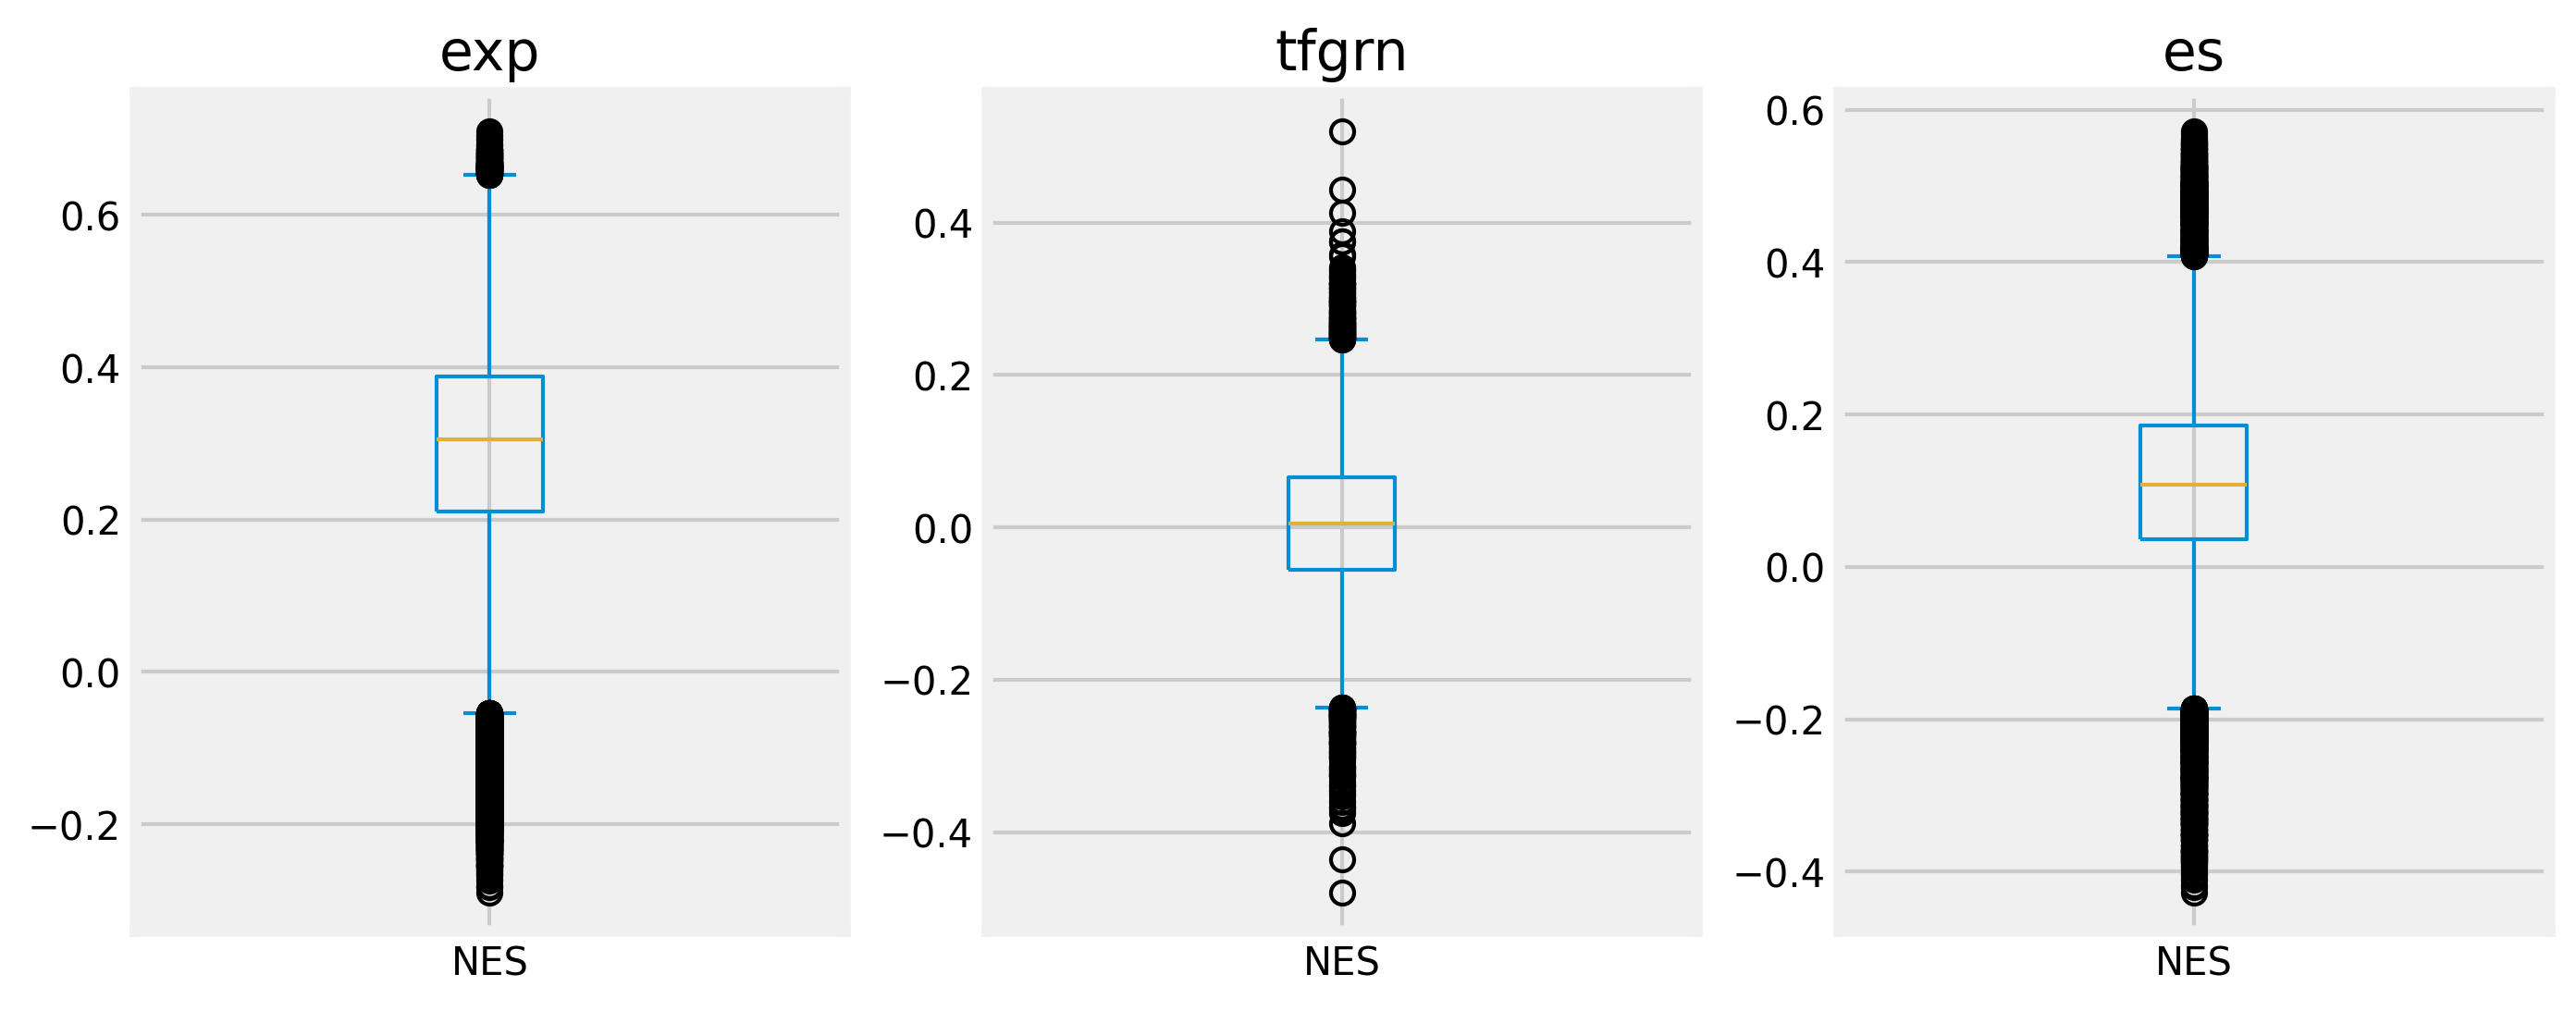

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,4), dpi=300)

ssgsea_dict['exp']['NES'].plot(kind='box', ax = ax1)
ssgsea_dict['tfgrn']['NES'].plot(kind='box', ax = ax2)
ssgsea_dict['es']['NES'].plot(kind='box', ax = ax3)

ax1.set_title('exp')
ax2.set_title('tfgrn')
ax3.set_title('es')

Text(0.5, 1.0, 'ef')

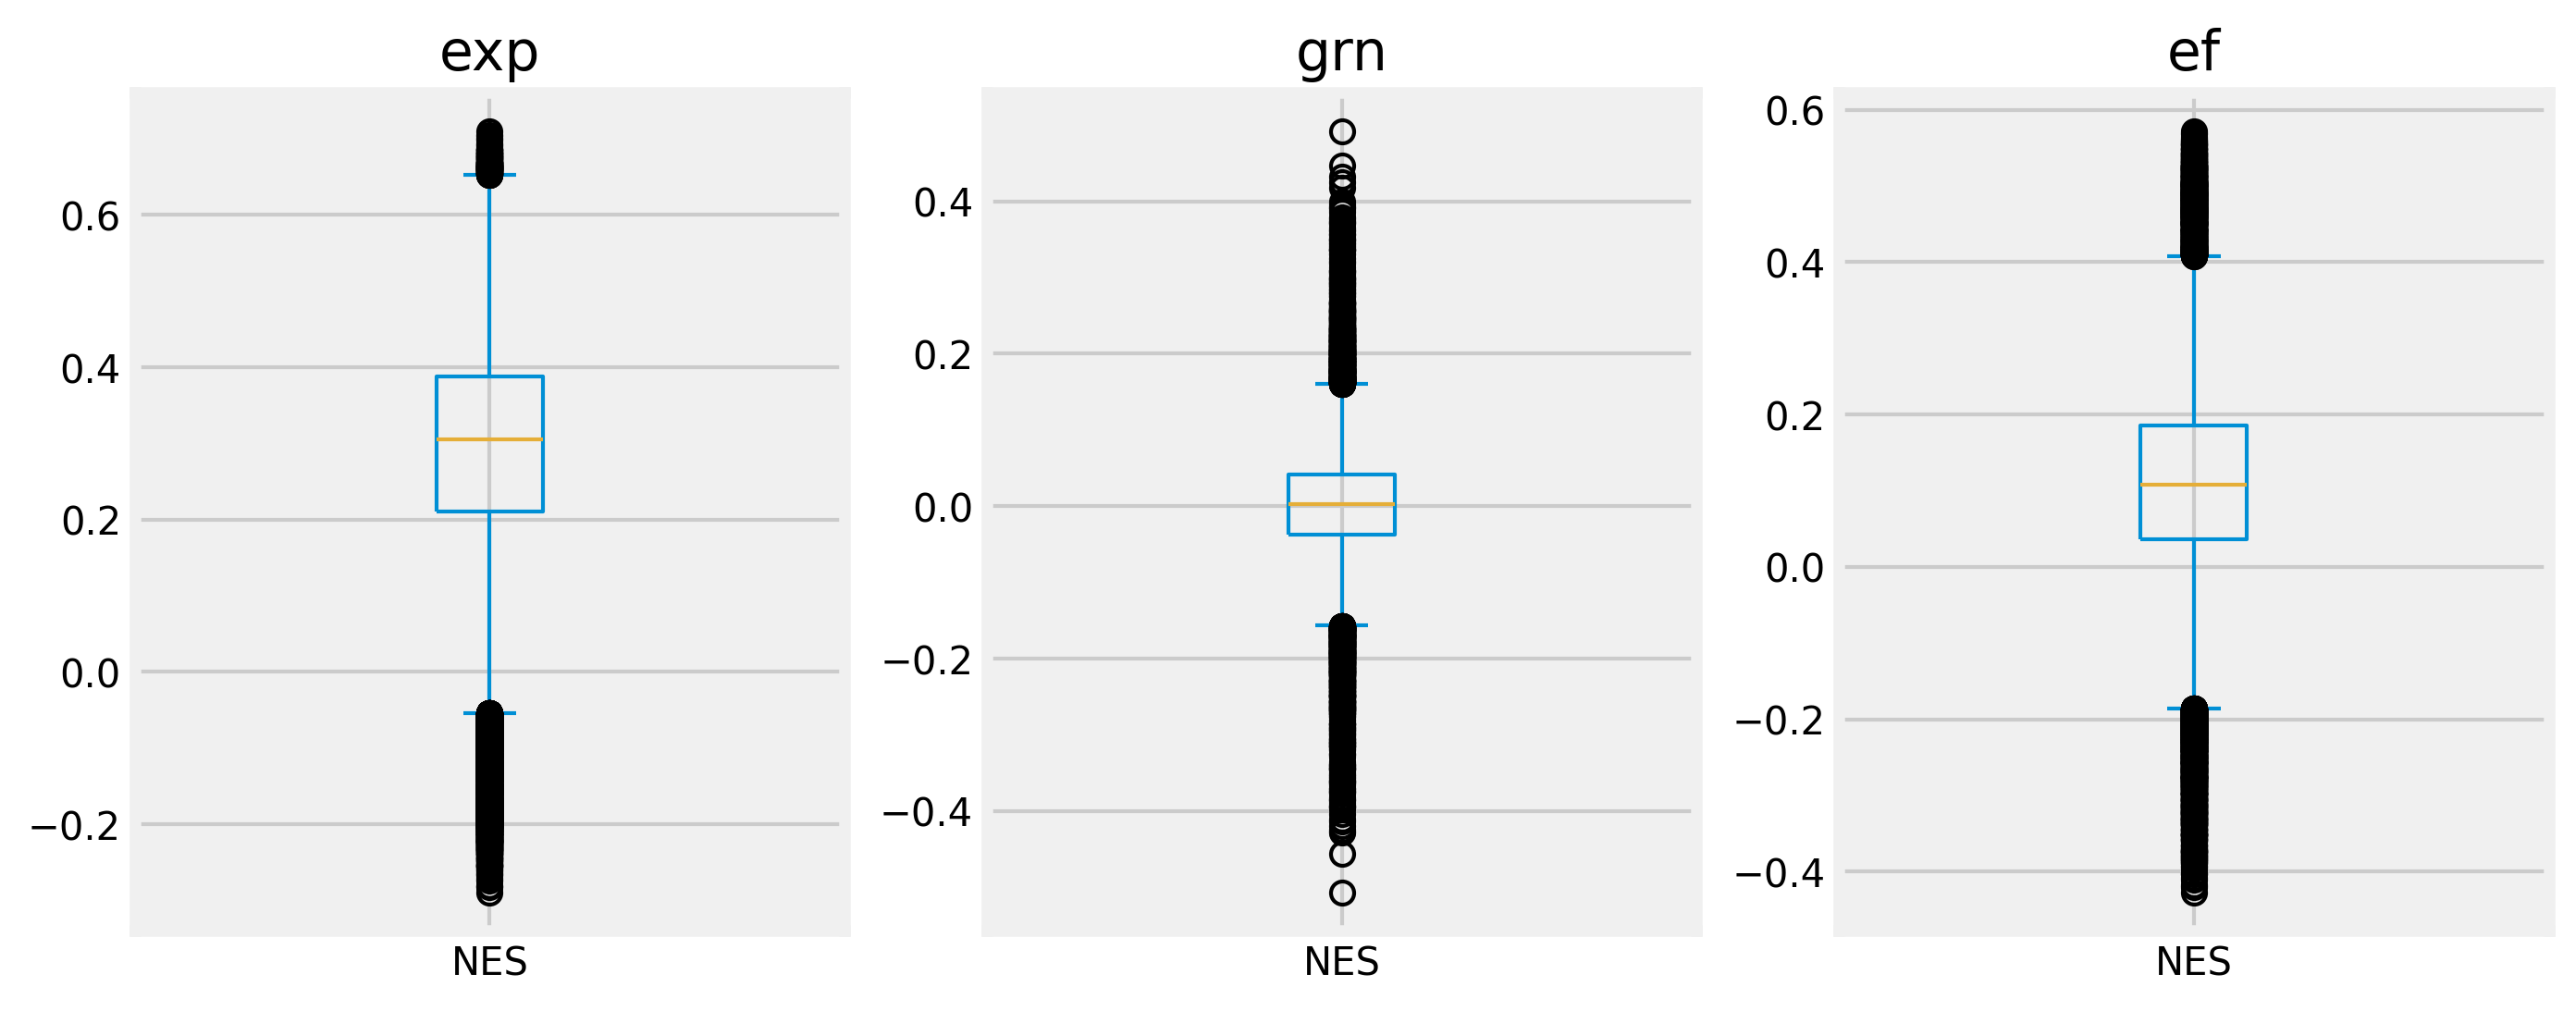

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,4), dpi=300)

ssgsea_dict['exp']['NES'].plot(kind='box', ax = ax1)
ssgsea_dict['grn']['NES'].plot(kind='box', ax = ax2)
ssgsea_dict['ef']['NES'].plot(kind='box', ax = ax3)

ax1.set_title('exp')
ax2.set_title('grn')
ax3.set_title('ef')